## Basic flow in an examplary MIR - classification research task

This notebook is designed to demonstrate basic/common flow of processes in an MIR classification task: "Automatic instrument recognition". This notebook should be considered as an educational material rather than research material. Various segments of it aim to raise a question for discussion rather than presenting a state of the art solution.
![MIR classification task basic flow](https://raw.githubusercontent.com/MTG/MIRCourse/master/notebooks/figures/MIRresearchOverview_1.png)

![Research design](figures/MIRresearchOverview_1.png)

* Defining the context, data space, reqirements, specifications <-> Literature review
* Curating the research dataset (available datasets, common/standard representation formats)
* Designing the flow, algorithms/processes/methods and implementation
* Evaluation

## A classification task: instrument recognition

* We define the task as automatic instrument recognition for monophonic isolated notes recordings. 
* The task is a classification task hence our first aim is gather a set of isolated note recordings for various instruments. 
* Our algorithmic design design will base on the standard flow of feature extraction fed to a classifier  
* At the end we will use standard evaluation measures of automatic classification to test our approach.

In [1]:
# Comment-out the next line(!pip instal..) if you are running the notebook locally 
# using our docker image
#Install Essentia in the current Colab session. 

#Basic imports
import os
import matplotlib.pyplot as plt
import essentia.standard as ess
import numpy as np


## Collecting raw data and investigating its nature

### Dowloading dataset files

**Collect file lists for each instrument**

In [2]:
#main_data_dir = '../data/instrument'
main_data_dir = '../data/hindustani_tabla'

inst_files = [] #list of all files
for file in os.listdir(main_data_dir+'/audios/'):
    if (file.endswith('.aif') or file.endswith('.aiff') or file.endswith('.wav')):
        file_name = os.path.join(main_data_dir,'audios',file)
        inst_files.append(file_name)

#Let's print the list of files
inst_files

['../data/hindustani_tabla/audios/ben_23.wav',
 '../data/hindustani_tabla/audios/dli_6.wav',
 '../data/hindustani_tabla/audios/ajr_10_ajr.wav',
 '../data/hindustani_tabla/audios/ajr_10_dli.wav',
 '../data/hindustani_tabla/audios/ajr_11.wav',
 '../data/hindustani_tabla/audios/ajr_12.wav',
 '../data/hindustani_tabla/audios/ajr_9.wav',
 '../data/hindustani_tabla/audios/ben_19.wav',
 '../data/hindustani_tabla/audios/ben_20.wav',
 '../data/hindustani_tabla/audios/ben_21.wav',
 '../data/hindustani_tabla/audios/ben_22.wav',
 '../data/hindustani_tabla/audios/frk_28.wav',
 '../data/hindustani_tabla/audios/frk_30.wav',
 '../data/hindustani_tabla/audios/frk_31.wav',
 '../data/hindustani_tabla/audios/luc_14.wav',
 '../data/hindustani_tabla/audios/luc_16.wav',
 '../data/hindustani_tabla/audios/luc_17.wav',
 '../data/hindustani_tabla/audios/luc_18.wav',
 '../data/hindustani_tabla/audios/pjb_75.wav',
 '../data/hindustani_tabla/audios/pjb_76.wav',
 '../data/hindustani_tabla/audios/pjb_77.wav',
 '../da

Now that we have gather a small research dataset, we can now focus designing the basic flow for our classification task

![Basic flow](https://raw.githubusercontent.com/MTG/MIRCourse/master/notebooks/figures/classification_basicFlow.png)

### Investigating and preprocessing raw data

It is often very useful to first check a few samples from the dataset to decide what preprocessing steps are required. Let's have a look at the waveform of one sample recording for each instrument

Sample waveform plots


<IPython.core.display.Javascript object>


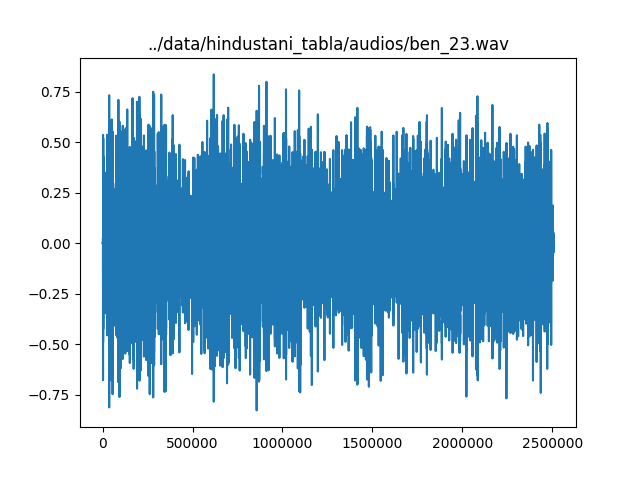

In [4]:
# Raw-data preprocess analysis parameters
%matplotlib notebook
fs = 44100

print("Sample waveform plots")
sample_file = inst_files[0]
x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()

plt.plot(x)
plt.title(sample_file)
plt.show()

The recordings include a series of isolated notes for flute, violin and Eb-Clarinet and isolated notes for vibraphone. We could split the series of isolated notes to create the samples.

Splitting/segmentation could be performed based on energy threshold. Below, a list of heuristically selected values are used. 

### Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps(such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning format change. 

In the downloaded data set, recordings include a sequence of isolated notes played in sequence which could be split into isolated notes. We would like to investigate the option of spliting using a fixed energy threshold (which would help us seperate notes using the silence regions). Let's define a function to perform this operation, visualize some samples to observe the effectiveness of the process.

In [5]:
# Raw-data preprocess analysis parameters
windowSize = 1024#4096 * 4
hopSize = 512#4096 * 2
NRG_threshold_ratio = 0.1 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [7]:
#Function definition
def split_file_from_ann(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    filename=filename.replace('audios','onsNoMap')
    filename=filename.replace('wav','csv')
    onsets=np.loadtxt(filename,delimiter=',',usecols=0)
    bols=np.loadtxt(filename,delimiter=',',usecols=1,dtype=str)
    for i in range(len(bols)):
        bols[i]=bols[i].strip()
    start_indexes=np.array(onsets*fs,dtype=int)
    stop_indexes=np.array(onsets[1:]*fs,dtype=int)
    stop_indexes=np.append(stop_indexes,len(x))
    return (start_indexes, stop_indexes, bols)

Let's visualize three files per instrument to check if splitting looks fine.

<IPython.core.display.Javascript object>


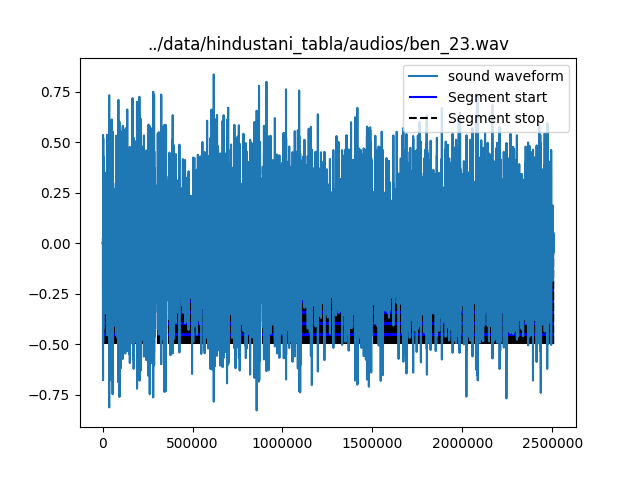

In [8]:
#%matplotlib notebook

sample_file=inst_files[0]
x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
(start_indexes, stop_indexes, bols) = split_file_from_ann(sample_file, params)
plt.title(sample_file)
plt.plot(x, label = 'sound waveform')
plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


The decision boundaries look fine, let's use the function to 
* get segment boundaries and crop segments, 
* amplitude normalize them and save all segments in a new folder

In [9]:
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir):#creating the directory
    os.mkdir(segments_dir)

segment_files = []
bol_counts={}
for sample_file in inst_files:
    file_count=0
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    (start_indexes, stop_indexes, bols) = split_file_from_ann(sample_file, params)
    #Croping segments
    for start, stop in zip(start_indexes, stop_indexes):
        #if stop - start > fs/3:#let's only keep segments larger than 1/3 second
        x_seg = x[start: stop]
        #Final check for amplitude (to avoid silent segments selection due to noise in split function)
        if(np.max(np.abs(x_seg)) > 0.05):
            #Amplitude normalisation
            x_seg = x_seg / np.max(np.abs(x_seg))
            
            bol_curr=bols[file_count]
            if not os.path.exists(os.path.join(segments_dir,bol_curr)):#creating the directory
                os.mkdir(os.path.join(segments_dir,bol_curr))
            if bol_curr in bol_counts.keys():
                bol_counts[bol_curr]+=1
            else:
                bol_counts[bol_curr]=0
            
            filename = os.path.join(segments_dir,  bols[file_count], bol_curr + '_' + str(bol_counts[bol_curr]) + '.wav')
            ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
            file_count +=1
            segment_files.append(filename)

print(len(segment_files),'segment files created')

8226 segment files created


In [0]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

#delete_files_in_dir(segments_dir)

Segments saved into separate files. Check the "data/instrument/segments/" folder.

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html). 

Let's first run it for a file and check its output:

In [12]:
import essentia.standard as es

#Running music extractor for a file:
file = segment_files[0]#simply pick the first file in the list
features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(file)

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [13]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [14]:
#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = os.path.join(segments_dir,'data.csv')
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in segment_files:
        if '.wav' in file:
            file_count +=1
            if file_count % 20 == 0:#print name of a file every 20 files
                print(file_count, "files processed, current file: ",file)
            features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            instrument = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + instrument + '\n'
            writer.write(line2write)
print("A total of ",file_count, "files processed")

20 files processed, current file:  ../data/hindustani_tabla/segments/NA/NA_3.wav
40 files processed, current file:  ../data/hindustani_tabla/segments/RA/RA_1.wav
60 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_10.wav
80 files processed, current file:  ../data/hindustani_tabla/segments/GA/GA_5.wav
100 files processed, current file:  ../data/hindustani_tabla/segments/GE/GE_3.wav
120 files processed, current file:  ../data/hindustani_tabla/segments/RA/RA_8.wav
140 files processed, current file:  ../data/hindustani_tabla/segments/KA/KA_7.wav
160 files processed, current file:  ../data/hindustani_tabla/segments/KE/KE_5.wav
180 files processed, current file:  ../data/hindustani_tabla/segments/RA/RA_12.wav
200 files processed, current file:  ../data/hindustani_tabla/segments/DA/DA_9.wav
220 files processed, current file:  ../data/hindustani_tabla/segments/GA/GA_10.wav
240 files processed, current file:  ../data/hindustani_tabla/segments/GE/GE_10.wav
260 files proces

1980 files processed, current file:  ../data/hindustani_tabla/segments/DHI/DHI_53.wav
2000 files processed, current file:  ../data/hindustani_tabla/segments/KA/KA_64.wav
2020 files processed, current file:  ../data/hindustani_tabla/segments/NA/NA_382.wav
2040 files processed, current file:  ../data/hindustani_tabla/segments/RA/RA_72.wav
2060 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_235.wav
2080 files processed, current file:  ../data/hindustani_tabla/segments/KDA/KDA_9.wav
2100 files processed, current file:  ../data/hindustani_tabla/segments/GA/GA_131.wav
2120 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_252.wav
2140 files processed, current file:  ../data/hindustani_tabla/segments/NA/NA_393.wav
2160 files processed, current file:  ../data/hindustani_tabla/segments/KI/KI_147.wav
2180 files processed, current file:  ../data/hindustani_tabla/segments/KI/KI_150.wav
2200 files processed, current file:  ../data/hindustani_tabla/segm

3900 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_632.wav
3920 files processed, current file:  ../data/hindustani_tabla/segments/KI/KI_301.wav
3940 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_642.wav
3960 files processed, current file:  ../data/hindustani_tabla/segments/KI/KI_305.wav
3980 files processed, current file:  ../data/hindustani_tabla/segments/RE/RE_107.wav
4000 files processed, current file:  ../data/hindustani_tabla/segments/DHE/DHE_111.wav
4020 files processed, current file:  ../data/hindustani_tabla/segments/KI/KI_311.wav
4040 files processed, current file:  ../data/hindustani_tabla/segments/DA/DA_84.wav
4060 files processed, current file:  ../data/hindustani_tabla/segments/KA/KA_284.wav
4080 files processed, current file:  ../data/hindustani_tabla/segments/RE/RE_117.wav
4100 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_669.wav
4120 files processed, current file:  ../data/hindustani_tabla/se

5820 files processed, current file:  ../data/hindustani_tabla/segments/NA/NA_627.wav
5840 files processed, current file:  ../data/hindustani_tabla/segments/KI/KI_482.wav
5860 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_1043.wav
5880 files processed, current file:  ../data/hindustani_tabla/segments/TRA/TRA_53.wav
5900 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_1052.wav
5920 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_1058.wav
5940 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_1063.wav
5960 files processed, current file:  ../data/hindustani_tabla/segments/RA/RA_227.wav
5980 files processed, current file:  ../data/hindustani_tabla/segments/DHE/DHE_207.wav
6000 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_1078.wav
6020 files processed, current file:  ../data/hindustani_tabla/segments/NA/NA_660.wav
6040 files processed, current file:  ../data/hindustani_t

7740 files processed, current file:  ../data/hindustani_tabla/segments/DHI/DHI_140.wav
7760 files processed, current file:  ../data/hindustani_tabla/segments/NA/NA_845.wav
7780 files processed, current file:  ../data/hindustani_tabla/segments/TA/TA_1438.wav
7800 files processed, current file:  ../data/hindustani_tabla/segments/GE/GE_347.wav
7820 files processed, current file:  ../data/hindustani_tabla/segments/GE/GE_351.wav
7840 files processed, current file:  ../data/hindustani_tabla/segments/GE/GE_352.wav
7860 files processed, current file:  ../data/hindustani_tabla/segments/RA/RA_322.wav
7880 files processed, current file:  ../data/hindustani_tabla/segments/GE/GE_361.wav
7900 files processed, current file:  ../data/hindustani_tabla/segments/DHI/DHI_148.wav
7920 files processed, current file:  ../data/hindustani_tabla/segments/NA/NA_857.wav
7940 files processed, current file:  ../data/hindustani_tabla/segments/RA/RA_327.wav
7960 files processed, current file:  ../data/hindustani_tabl

## Analysis of features

All extracted features are saved in data.csv. Columns represent features and rows each file/sample. This is a typical format in a large number of machine learning datasets (see a few of the dataset here: https://archive.ics.uci.edu/ml/index.php or other "Data Science" examples on the web).  

***The use of a common format for data representation is beneficial in both making use of existing tools (such as Pandas) as well as contributing to the community with resources that are easy to use.***

Let's load the data and start investigating the features. We can use Pandas(a package largely used in data science) to read data and access statistical description of the features. 

In [15]:
import pandas as pd

In [16]:
#Read data
data = pd.read_csv(data_file)
#Let's see the first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.990684,16.209543,5.112620,0.310539,0.095095,8.714972,10.567465,0.205856,1.690208,4.668475,...,102.775909,5.494711,2.337120,5515621.50,9143398.000,1.953452,0.956851,0.016567,0.005066,dha
1,0.990684,17.533453,3.940596,0.307696,0.094444,9.007112,7.921611,-0.081761,1.561860,3.756710,...,44.577965,5.347005,1.534002,3320933.25,2586233.000,2.646414,1.475472,0.014160,0.005437,ghi
2,0.990684,14.870707,5.186862,0.194606,0.051844,9.956877,7.004032,2.398179,0.510064,8.609349,...,171.052856,2.479351,0.655635,7842132.00,8657170.000,0.381401,0.470859,0.011091,0.005578,da
3,0.990684,13.847533,6.711755,0.201228,0.061377,14.170911,19.312923,2.614032,1.957881,9.170063,...,198.428970,3.141576,0.836271,3347650.75,1779492.125,0.259717,0.370635,0.017171,0.007386,na
4,0.990684,8.904128,2.712310,0.133986,0.042492,5.303381,5.074034,1.473745,0.818135,14.532621,...,1031.232300,2.309214,0.255312,4379665.50,3195731.500,0.760753,0.488687,0.037354,0.011005,ga


All features are represented with columns and the last column('instrument') carries the class information

Always check if your data involves Nan values and clean them (by: simply removing the sample, or replacing the Nan value by a real value (such as the median of that feature)) 

In [17]:
data.isnull().sum().sum()#sums a matrix of True/False values obtained by checking if each value is Nan

0

**Observation:** No Nan value, proceed ..

As the next step, having a look at descriptive statistics of the features would be useful. Let's do that

In [18]:
#Descriptive statistics of the features:
data.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,...,8226.000000,8226.000000,8226.000000,8226.000000,8.226000e+03,8.226000e+03,8226.000000,8226.000000,8226.000000,8226.000000
mean,0.990684,12.179846,3.817329,0.198944,0.058686,11.370909,8.217890,1.889667,0.919312,10.135808,...,704.089565,379.485016,2.943374,0.824442,6.179034e+06,5.659309e+06,0.762012,0.543582,0.019078,0.008197
std,0.000000,3.567188,1.552311,0.066855,0.026877,19.194156,14.561664,1.325920,0.594835,5.460023,...,412.095310,524.010791,0.958635,0.540012,2.492026e+06,3.184346e+06,0.548682,0.350242,0.009349,0.004748
min,0.990684,3.570559,0.113060,0.060512,0.000885,-1.038581,0.164573,-1.429842,0.043201,0.455221,...,104.589844,0.000000,1.299267,0.008442,1.281253e+06,3.051572e+04,0.000000,0.000000,0.002441,0.000244
25%,0.990684,9.532571,2.653580,0.146330,0.038204,3.138485,2.372752,1.036449,0.528524,5.887333,...,418.044777,122.270868,2.281809,0.461884,4.310132e+06,2.997399e+06,0.349134,0.271609,0.012016,0.004849
50%,0.990684,11.778855,3.721113,0.186636,0.055951,6.268304,4.342436,1.670711,0.781569,9.167992,...,645.996094,252.493546,2.712009,0.652457,5.722420e+06,5.443595e+06,0.615438,0.463561,0.018066,0.007515
75%,0.990684,14.382507,4.837404,0.241655,0.076029,12.498389,8.554571,2.497103,1.140802,13.577046,...,908.603287,458.599792,3.332689,1.010979,7.618842e+06,8.048540e+06,1.021707,0.732093,0.024902,0.010554
max,0.990684,25.948910,9.404156,0.515457,0.180340,449.684418,401.880859,14.889808,7.944852,37.153751,...,5507.116699,8246.027344,9.424209,4.261248,1.923276e+07,1.585035e+07,4.455418,2.688066,0.076660,0.057058


**Observation:** min, max, mean values of the features vary a lot, we need to normalise them

### Preprocessing of the features

**Normalisation of the features**

In [19]:
data_modif = data.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [20]:
data_modif.describe()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev
count,8226.0,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,...,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000,8226.000000
mean,0.0,0.384715,0.398690,0.304284,0.322090,0.027532,0.020047,0.203406,0.110877,0.263787,...,0.110967,0.046020,0.202353,0.191873,0.272834,0.355806,0.171030,0.202220,0.224157,0.139985
std,0.0,0.159404,0.167075,0.146952,0.149767,0.042585,0.036249,0.081247,0.075280,0.148780,...,0.076278,0.063547,0.117987,0.126978,0.138820,0.201288,0.123149,0.130295,0.125970,0.083565
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.266419,0.273436,0.188634,0.207955,0.009267,0.005497,0.151124,0.061420,0.148020,...,0.058020,0.014828,0.120929,0.106622,0.168726,0.187542,0.078362,0.101042,0.129007,0.081055
50%,0.0,0.366796,0.388334,0.277229,0.306851,0.016211,0.010400,0.189989,0.093445,0.237415,...,0.100214,0.030620,0.173877,0.151433,0.247398,0.342170,0.138132,0.172451,0.210526,0.127984
75%,0.0,0.483143,0.508481,0.398165,0.418733,0.030034,0.020885,0.240627,0.138908,0.357557,...,0.148822,0.055615,0.250269,0.235735,0.353039,0.506834,0.229318,0.272349,0.302632,0.181467
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Observation:** Now the features are normalised in [0,1] range, proceed to converting data into matrices that can be fed into classifiers

**IMPORTANT:** Various other preprocessing may be required based on the nature of your data. Refer to your machine learning course for the preprocessing step. We will also skip discussions on feature selection(another important topic) here and leave it to your machine learning course. 

We should check if our data is balanced:

In [21]:
data_modif.instrument.value_counts()

ta      1493
na       907
ki       705
ka       621
dha      581
ti       538
ge       396
taa      391
ra       338
re       294
dhe      277
ga       276
ghi      201
dhi      156
dhin     149
da       130
ke        97
kda       91
dhet      65
tra       64
tii       64
di        63
tin       61
ghe       48
kat       43
tit       41
gi        39
din       36
te        18
kii       10
ghen       8
kar        8
tu         6
n          3
chap       2
kru        2
kra        1
kri        1
ding       1
d          1
Name: instrument, dtype: int64

**Observation:** our data is imbalanced, ups.... refer to your machine learning course for the problem of working with imbalanced datasets. Here, we will simply throw out some samples to balance our data

### Balancing the data
Let's simply pick 36 samples randomly from each instrument samples (since the lowest number of samples in a class is 36 (flute))

In [23]:
min_number = min(data_modif.instrument.value_counts())
violin_data = data_modif[data_modif.instrument == 'violin'].sample(n = min_number)
vibraphone_data = data_modif[data_modif.instrument == 'vibraphone'].sample(n = min_number)
ebclar_data = data_modif[data_modif.instrument == 'ebclar'].sample(n = min_number)
flute_data = data_modif[data_modif.instrument == 'flute']
#Merging after downsampling
data_modif = pd.concat([ebclar_data, flute_data, violin_data, vibraphone_data])
#Checking the balance again
data_modif.instrument.value_counts()

violin        36
flute         36
ebclar        36
vibraphone    36
Name: instrument, dtype: int64

Now we can form the input-output matrices that can be fed into classifiers. You can refer to [the tutorials of the scikit learn package](https://scikit-learn.org/stable/tutorial/index.html) to get familiar with the input-output formats.

In [22]:
#input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
#Creating output values
data_modif.instrument = pd.Categorical(data_modif.instrument)#convert to categorical data
y = np.array(data_modif.instrument.cat.codes) #create label encoded outputs
#Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [ 0.          0.56478622  0.53810228  0.54957603  0.52497741  0.02163979
  0.02589612  0.10022875  0.20843836  0.11480714  0.11962638  0.30736455
  0.47012923  0.          0.7363961   0.77057544  0.67927803  0.71747717
  0.14999956  0.15677423  0.42174901  0.4203946   0.09093858  0.37456891
  0.26478974  0.07576653  0.64258543  0.          0.70830106  0.
  0.64258552  0.          0.62718785  0.46395739  0.59280981  0.48208091
  0.07037638  0.07947866  0.18626751  0.34802406  0.10203489  0.04644114
  0.39708292  0.45183206  1.          0.          1.          0.
  0.07967033  0.51507872  0.10508323  0.02379139  0.21854304  0.22523971
  0.91185265  0.09501263  0.09007265  0.0964151   0.01094657  0.01770098
  0.03477325  0.07225423  0.08259935  0.05338651  0.36720887  0.12059639
  0.38432634  0.69498362  0.12123834  0.25726435  0.41124645  0.40152804
  0.29217004  0.22287126  0.06462633  0.01246369  0.5163661   0.54756267
  0.23587821  0.57604154  0.43844409

Let's check content of the outputs vector 

In [23]:
#All output values: ebclar: 0, flute: 1, vibraphone: 2, violin: 3
print(y)

[ 3 15  2 ..., 12 34 31]


In [24]:
#Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [25]:
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (5511, 84) , Size of train output vector:  (5511,)
Size of test features matrix:  (2715, 84) , Size of test output vector:  (2715,)


Now we can train a machine learning model. Let's pick SVM and feed out data to run training

In [26]:
from sklearn import svm
clf = svm.SVC(gamma = 'scale')
clf.fit(X_train, y_train)                         

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

The model is trained. One can perform prediction a set of features. If we feed the features of the test set, we expect to find the classes of the test set (true values of it are stored in y_test). We will refer to the output as: predicted classes (y_pred)

In [27]:
y_pred = clf.predict(X_test)

In [28]:
#Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([False,  True,  True, ...,  True, False,  True], dtype=bool)

In [29]:
#Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.357274401473


As the final step, let's also print the **confusion matrix**

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.instrument)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

ValueError: Shape of passed values is (37, 37), indices imply (40, 40)

In [37]:
np.where(y_test==39)

(array([], dtype=int64),)

Now that we have a trained model, we have the tools to perform automatic instrument classification of isolated notes. Here is the sequence of function call for that: